<a href="https://colab.research.google.com/github/Ali-7800/ME471/blob/main/projects/project_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

# Problem 1.2
Plot the displacement, strain, and stress solutions over the domain of the bar.

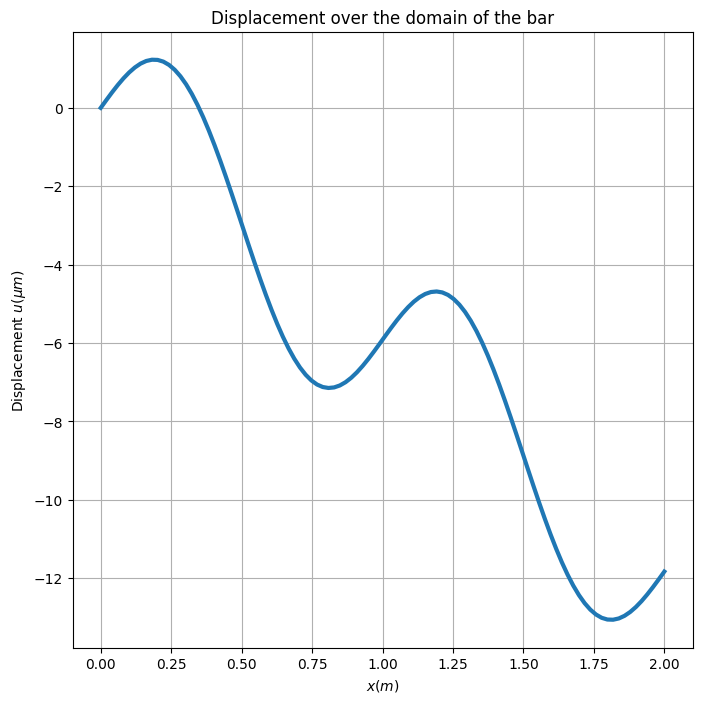

In [66]:
L = 2 #m
E = 100e9 #100GPa
F = 1e6 # N
A = 1 # m^2
x = np.linspace(0,2,100)
u_analytical = lambda x:((F-(1e7*A*L/(4*np.pi)))*x+(1e7*A**2*L**2/(16*np.pi**2))*np.sin(4*np.pi*x/L))/(E*A)
plt.figure(figsize=(8, 8))
ax =plt.plot(x,u_analytical(x)*1e6,linewidth=3)
plt.xlabel("$x(m)$")
plt.ylabel("Displacement $u(\mu m)$")
plt.title("Displacement over the domain of the bar")
plt.grid()

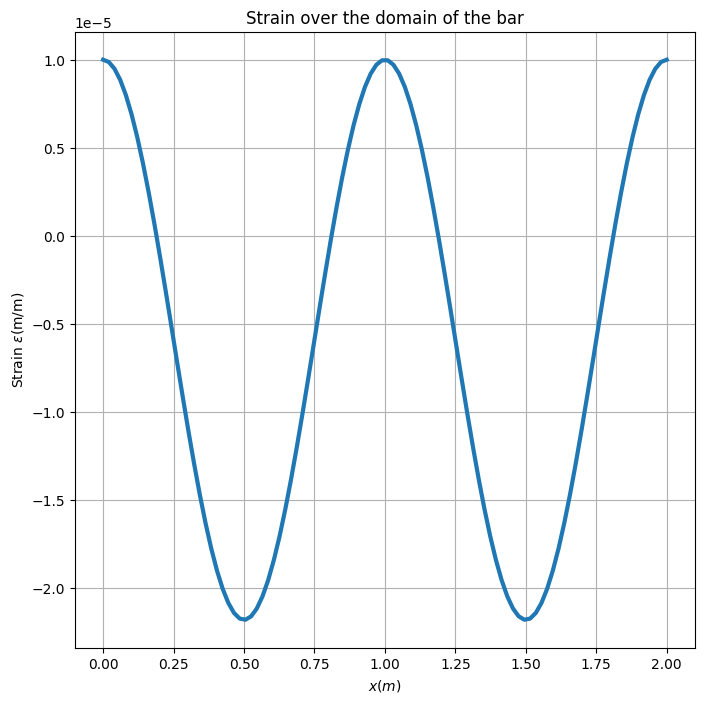

In [81]:
x = np.linspace(0,2,100)
strain_analytical = ((F-(1e7*A*L/(4*np.pi)))+(1e7*A*L/(4*np.pi))*np.cos(4*np.pi*x/L))/(E*A)
plt.figure(figsize=(8, 8))
plt.plot(x,strain_analytical,linewidth=3)
plt.xlabel("$x(m)$")
plt.ylabel("Strain $\epsilon$(m/m)")
plt.title("Strain over the domain of the bar")
plt.grid()

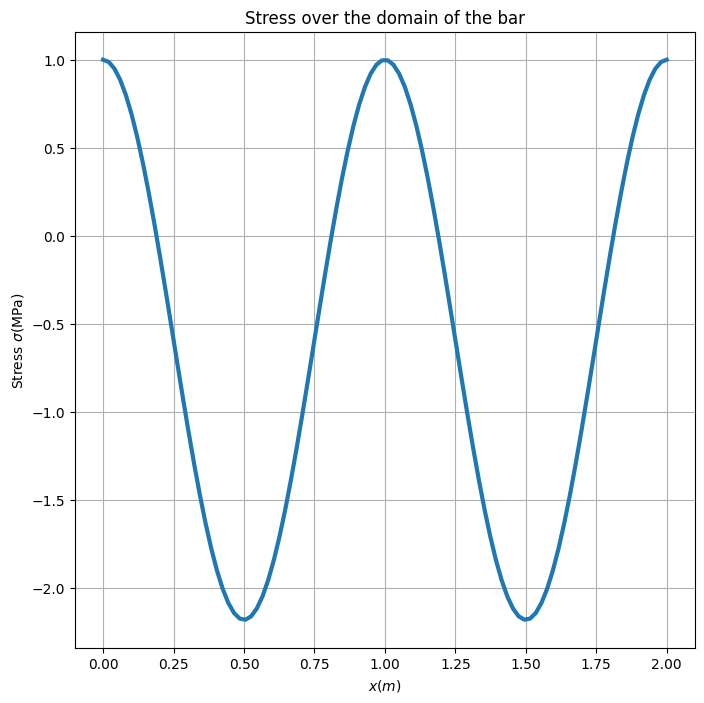

In [82]:
x = np.linspace(0,2,100)
E = 100e9 #100GPa
stress_analytical = E*strain_analytical
plt.figure(figsize=(8, 8))
ax =plt.plot(x,stress_analytical*1e-6,linewidth=3)
plt.xlabel("$x(m)$")
plt.ylabel("Stress $\sigma$(MPa)")
plt.title("Stress over the domain of the bar")
plt.grid()

# Problem 2.1
Write a 1D FEA code in Python to solve the problem described in Question 1 using linear 1D
rod elements.

In [117]:
class Fixed1DRodFEA:
  def __init__(
        self,
        length:float,
        end_force:float,
        cross_sectional_area:callable,
        youngs_modulus:callable,
        body_force:callable,
        ):
    self.length = length
    self.cross_sectional_area = cross_sectional_area
    self.youngs_modulus = youngs_modulus
    self.end_force = end_force
    self.body_force = body_force

  def assemble_stiffness_matrix(self,node_positions:np.ndarray,N:int):
    stiffness_matrix = np.zeros((N+1,N+1))
    for i in range(N):
      x1 = node_positions[i]
      x2 = node_positions[i+1]
      h_e = (x2-x1)
      EA_bar = sp.integrate.quad(lambda x: self.youngs_modulus(x)*self.cross_sectional_area(x), x1, x2)[0]/h_e
      stiffness_matrix[i:i+2,i:i+2] += (EA_bar/h_e)*np.array([[1,-1],[-1,1]])
    return stiffness_matrix[:1,:1],stiffness_matrix[:1,1:],stiffness_matrix[1:,:1],stiffness_matrix[1:,1:]#Kpp,Kpf,Kfp,Kff

  def find_load_vector(self,node_positions:np.ndarray,N:int):
    p = np.zeros_like(node_positions)
    for i in range(N):
      x1 = node_positions[i]
      x2 = node_positions[i+1]
      N1 = lambda x: (x-x2)/(x1-x2)
      N2 = lambda x: (x-x1)/(x2-x1)
      p[i] += sp.integrate.quad(lambda x: N1(x)*self.body_force(x)*self.cross_sectional_area(x), x1, x2)[0]
      p[i+1] += sp.integrate.quad(lambda x: N2(x)*self.body_force(x)*self.cross_sectional_area(x), x1, x2)[0]
    p[-1] += self.end_force
    return p[1:],p[:1] #return pf,pp

  def solve(self,N:int):
    node_positions = np.linspace(0,self.length,N+1) #N+1 nodes
    Kpp,Kpf,Kfp,Kff = self.assemble_stiffness_matrix(node_positions,N)
    pf,pp = self.find_load_vector(node_positions,N)
    U = np.zeros_like(node_positions)
    U[1:] = np.linalg.solve(Kff,pf) #This is Uf
    R = Kpf@U[1:] - pp #Up = 0 always in the case of a fixed rod
    strain = (U[1:]-U[:-1])/(node_positions[1:]-node_positions[:-1])
    stress = self.youngs_modulus(node_positions[:-1])*strain
    return node_positions,U,strain,stress,R

  def plot_stress(self,node_positions:np.ndarray,stress:np.ndarray):
    #plot for stress in MPa
    for i,stress_value in enumerate(stress):
      plt.plot(node_positions[i:i+2],np.array([stress_value,stress_value])*1e-6,"-r",linewidth=3,marker=".")
    plt.plot(node_positions[i:i+2],np.array([stress_value,stress_value])*1e-6,"-r",linewidth=3,label="FEA Solution",marker=".") #to get the legend label


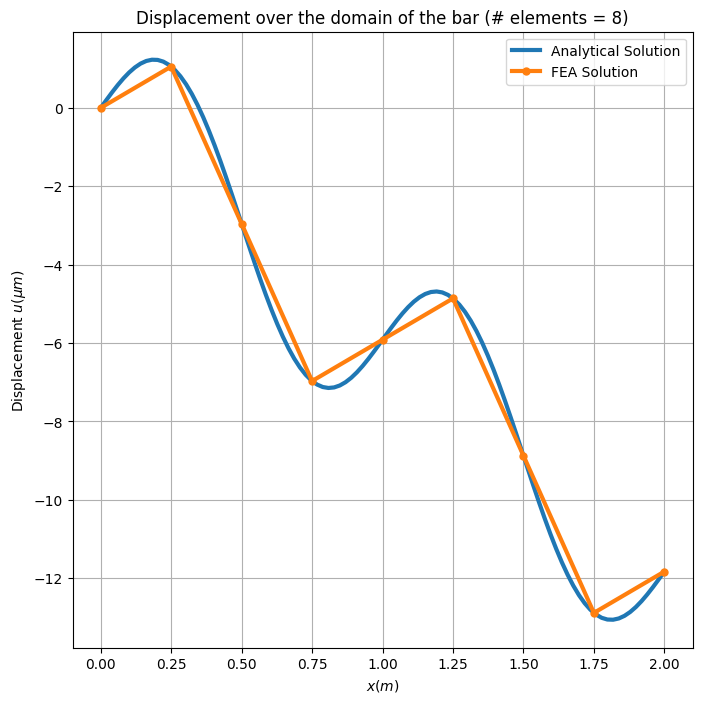

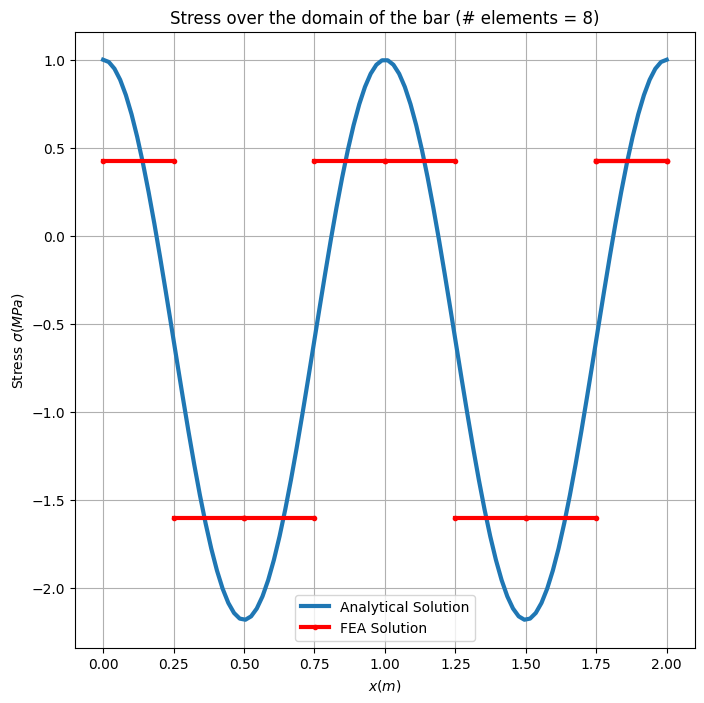

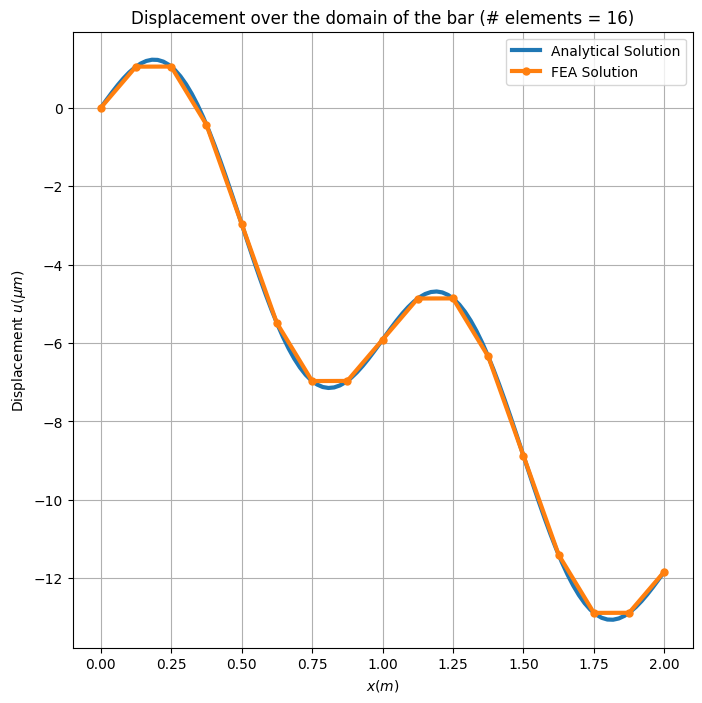

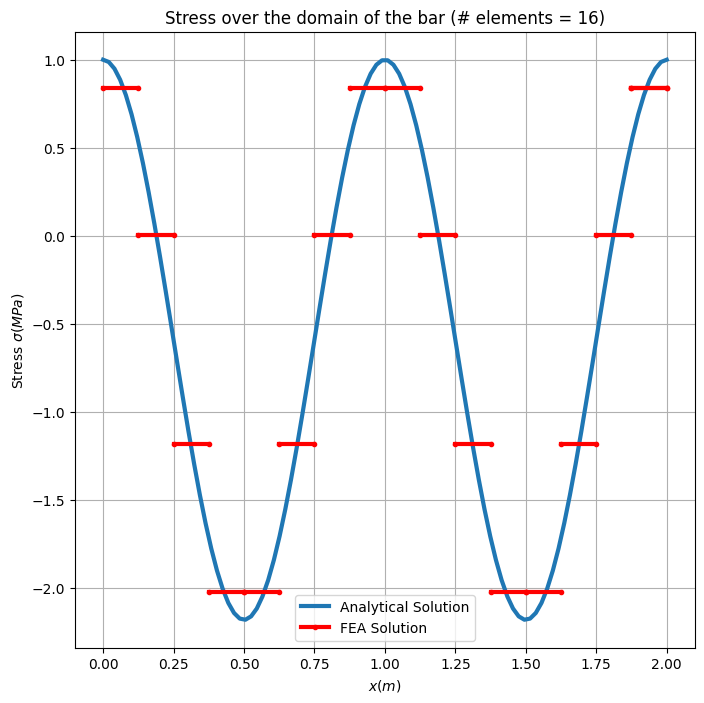

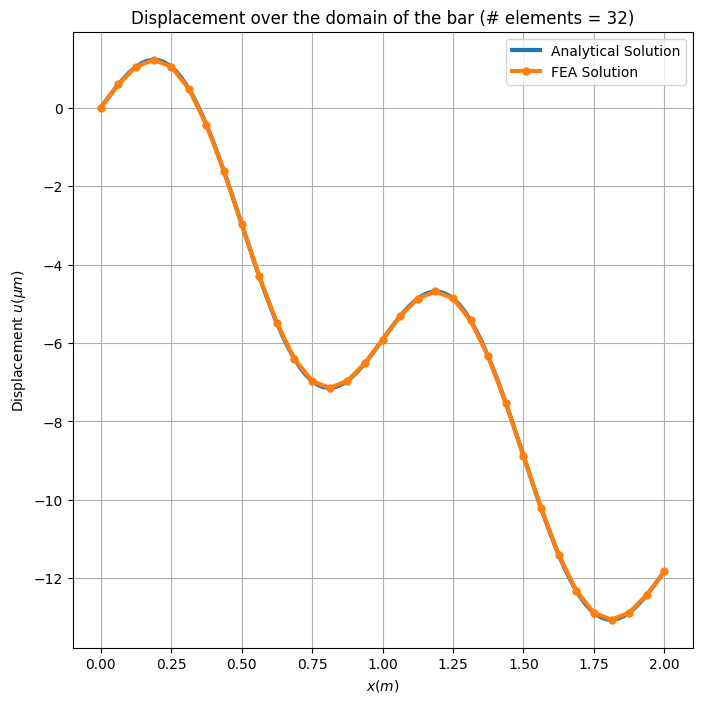

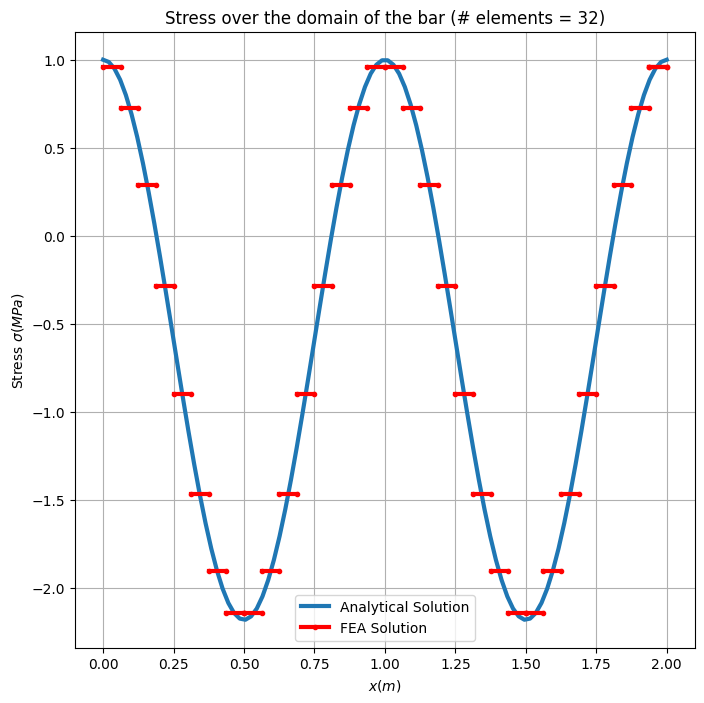

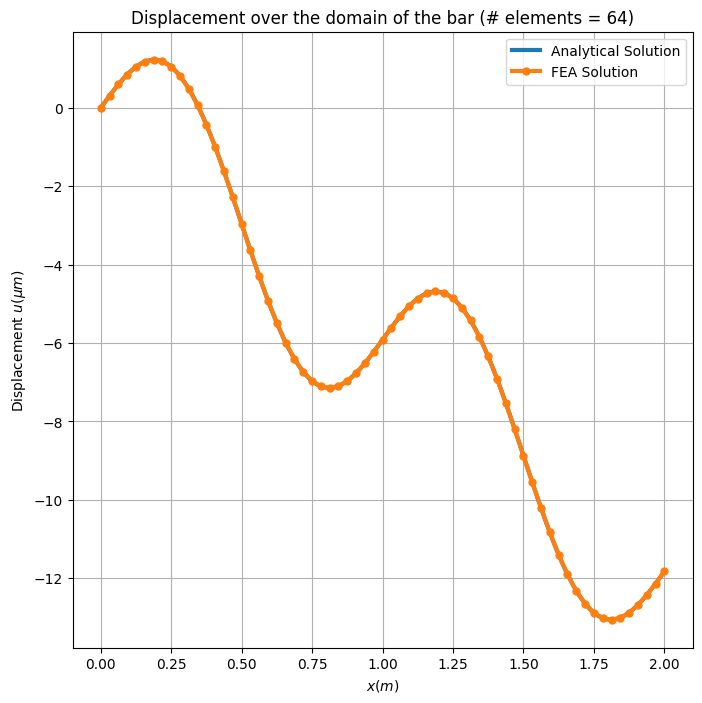

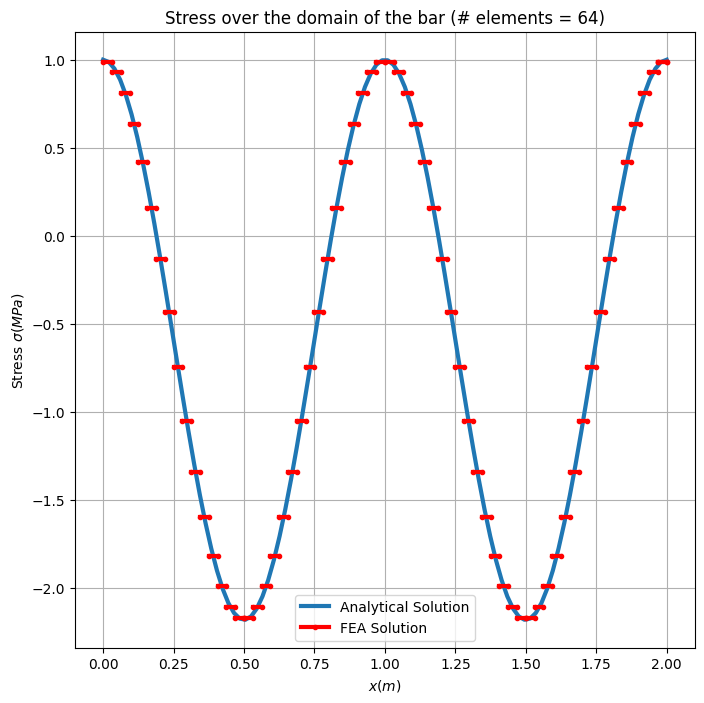

In [120]:
problem_1_rod = Fixed1DRodFEA(
    length=L,
    end_force=F,
    cross_sectional_area=lambda x:A,
    youngs_modulus=lambda x:E,
    body_force=lambda x:1e7*np.sin(4*np.pi*x/L),#N/m^3
)
meshes = [8,16,32,64]
for N in meshes:
  node_positions,u_FEA,strain,stress,R = problem_1_rod.solve(N)
  #plot for displacement
  plt.figure(figsize=(8, 8))
  plt.plot(x,u_analytical(x)*1e6,linewidth=3,label="Analytical Solution")
  plt.plot(node_positions,u_FEA*1e6,linewidth=3,label="FEA Solution",marker=".",markersize=10)
  plt.legend()
  plt.xlabel("$x(m)$")
  plt.ylabel("Displacement $u(\mu m)$")
  plt.title("Displacement over the domain of the bar (# elements = {0})".format(N))
  plt.grid()
  plt.figure(figsize=(8, 8))

  #plot for stress
  plt.plot(x,stress_analytical*1e-6,linewidth=3,label="Analytical Solution")
  problem_1_rod.plot_stress(node_positions,stress)
  plt.legend()
  plt.xlabel("$x(m)$")
  plt.ylabel("Stress $\sigma(MPa)$")
  plt.title("Stress over the domain of the bar (# elements = {0})".format(N))
  plt.grid()
